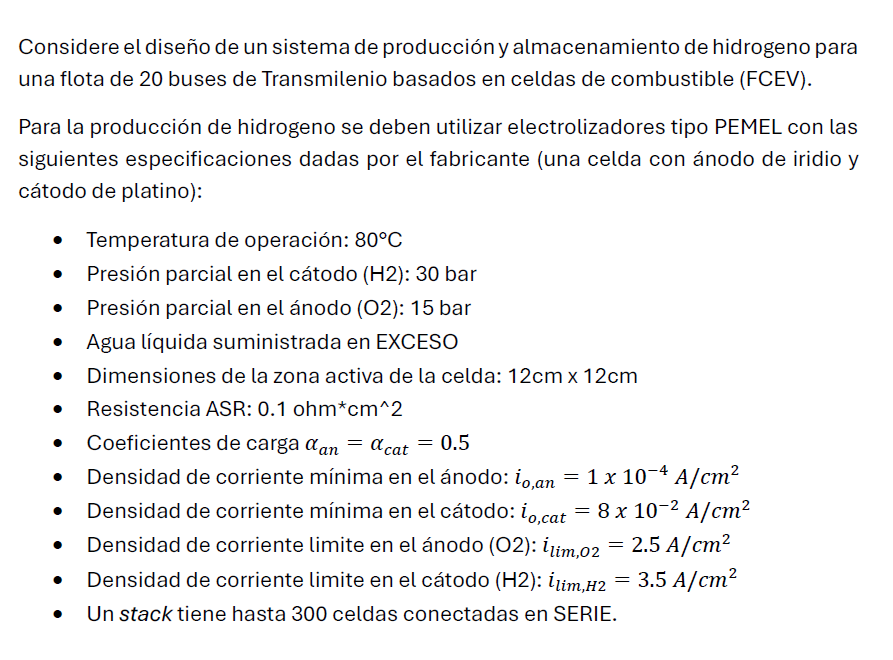

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 


In [ ]:
n_b = 20 #numero de buses
T_op = 80 #°C
P_cat = 30 #bar H2
P_an = 15 # bar O2

Dim_zon_act = 12.0 * 12.0 #cm2
ASR = 0.1 #ohm*cm2
alpha_an = 0.5
alpha_an_cat = 0.5
i_0_an = 1*10**-4 #A/cm2
i_0_an = 8*10**-2 #A/cm2
i_lim_02 = 2.5 #A/cm2
i_lim_H2 = 3.5 #A/cm2

n_celdas = 300 # numero de celdas 
